# How does window thickness affect the temperature of a room over the course of a typical October day in Massachusetts?

Annie Chu and Annie Tor

ModSim Studio 1

In [8]:
# import functions that will let us read .csv files
from pandas import read_csv

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question

The New England climate consists of hot summers and cold winters, magnifying the need for quality wall insulation. One of the factors that determine the insulative capabilities of a wall is a wall's thickness. So how does window thickness affect the temperature of a room over the course of a typical October day in Massachusetts?


In [9]:
filename = r'C:\Users\ator\Desktop\ModSim\Project2TempData.csv'
tables = read_csv(filename, header=0, index_col=0);
tables

,Temp
Hour,
0,281.48
1,281.48
2,278.71
3,278.15
4,277.59
5,277.59
6,277.59
7,277.04
8,277.04


10/30/2018
taking weighted average of 2 temperature based on window/wall ratio
sweeping R values (changing material)

total wall dimensions (length x width x thicKNESS): 5 meters by 5 meters by 0.1651 meters (6.5 in) 
glass thickness = 3 in

dhdt outputs joules
need specific heat (of materials, related to R) in to find temp change. 

NEXT STEPS
1. take outside temp data from internet
2. figure out how to implement it with temp_out
3. test the model
4. find R/C/density info for chosen materials
5. choose materials

specific heat (C) must have units of KJ/Kg * K
density must have units of Kg/m3. 

10/27/18 A Productive Meeting!!!

Refined question: How does the window size of a set wall area affect the temperature of a room over the course of a typical October day?

What we call a typical October day will be based off data for October 15th. 
We will be taking data from the outside and finding the equation of best fit for that data using the interpolate function.
Our model will use the differential equation 

dH/dt of plaster = (outside temperature - inside temperature) * area of plaster wall / R-value of plaster wall

dH/dt of window = (outside temperature - inside tempreature) * area of window / R-value of window

The outside temperature will come from our function based on outside data.
The first value for inside temperature will be hard-coded to typical room temperature, and all following values will be found recursively. 
The area of the plaster wall will come from the difference between a predetermined total wall area and the window area.
The area of the window will be swept across a range of values from 0 to a predetermined total wall area.
The R-value of the wall will be based off typical R-values for exterior walls and windows.

To find the inside temperature, we will convert our dH/dt values from heat energy units to temperature units, then add them to the previous inside temperature.

Since we only want to focus on the change of temperature over a day, t0 will be 0 (midnight) and t_end will be 24 (midnight of the next day).

We assume that the window and the plaster will act independently of each other. 
We are also assuming that there is essentially no effect from the Sun, meaning that no thermal energy coming directly from the Sun will be considered. To justify this assumption, our hypothetical window will be North-facing (away from the Sun).

In [10]:
def make_system(window_length, window_width, w_th, total_length, total_width, plaster_THICC, window_R, plaster_R, window_C, plaster_C, window_density, plaster_density):
    init = State(temp_in = 281)
    t0 = 0
    t_end = 23
    dt = 1
    
    total_area = total_length * total_width
    
    window_area = window_length * window_width
    window_volume = window_area * w_th
    
    plaster_area = total_area - window_area
    plaster_volume = plaster_area * plaster_THICC
    
    return System(init=init, 
                  t0 = t0, 
                  t_end = t_end, 
                  dt = dt, 
                  total_area = total_area,
                  window_area = window_area,
                  window_volume = window_volume,
                  plaster_area = plaster_area,
                  plaster_volume = plaster_volume,
                  window_length = window_length,
                  window_width = window_width,
                  w_th = w_th,
                  total_length = total_length,
                  total_width = total_width,
                  plaster_THICC = plaster_THICC,
                  window_R = window_R,
                  plaster_R = plaster_R, 
                  window_C = window_C,
                  plaster_C = plaster_C, 
                  window_density = window_density, 
                  plaster_density = plaster_density)

In [11]:
def update_func(state, t, system):
    
    Temp_in = state.temp_in
    
    delt_temp = tables.Temp[t] - Temp_in
    
    unpack(system)

    dTdt_plaster = 1000 * ((plaster_area * delt_temp) / (3600 * plaster_R * plaster_C * plaster_density * plaster_area * plaster_THICC))
    dTdt_window =  1000 * ((window_area * delt_temp) / (3600 * window_R * window_C * window_density * window_area * w_th))

    Temp_in += dTdt_plaster + dTdt_window
    
    return State(temp_in=Temp_in)

In [12]:
def run_simulation(system, update_func):
    unpack(system)
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
              
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    return frame

In [20]:
def sweep_thickness(window_length, window_width, w_thicknesses, total_length, total_width, plaster_THICC, window_R, plaster_R, window_C, plaster_C, window_density, plaster_density):
    sweep = SweepSeries()
    for w_th in w_thicknesses:
        system = make_system(window_length, window_width, w_th, total_length, total_width, plaster_THICC, window_R, plaster_R, window_C, plaster_C, window_density, plaster_density)
        results = run_simulation(system, update_func)
        sweep[system.w_th] = results
    return sweep

In [21]:
w_thicknesses = linspace(0.1, 1, 10)

sweep = sweep_thickness(0.5, 0.5, w_thicknesses, 3, 3, 0.25, 0.91, 5, 0.84, 1, 2600, 849)



,values
0.1,temp_in 0 281 1 281.001 2 281.00...
0.2,temp_in 0 281 1 281 2 281.00...
0.3,temp_in 0 281 1 281 2 281.00...
0.4,temp_in 0 281 1 281 2 281.00...
0.5,temp_in 0 281 1 281 2 281.00...
0.6,temp_in 0 281 1 281 2 28...
0.7,temp_in 0 281 1 281 2 28...
0.8,temp_in 0 281 1 281 2 28...
0.9,temp_in 0 281 1 281 2 28...
1.0,temp_in 0 281 1 281 2 28...


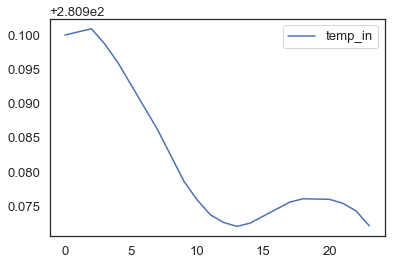

In [39]:
#label = 'thickness' + str(w_th)

thick1 = sweep[.2]
thick1.plot()


In [16]:
run_simulation

def plot_results(temp_out, temp_in):
    plot(temp_in-273, 'm-', label = "Temperature Inside")
    plot(temp_out-273, 'g:', label = "Temperature Outside")
    decorate(title = "from the windoOOWWWWWWWWW TO THE WALL",
            xlabel = "Hours",
            ylabel = "Temperature")
    
def plot_this(temp_in):
     plot(temp_in, 'm-', label = "Temperature Inside")
        


In [17]:
plot_results(results.temp_in, tables.Temp)

NameError: name 'results' is not defined

In [ ]:
plot_one(results.temp_in)